<a href="https://colab.research.google.com/github/mavzersener/derin_ogrenme/blob/master/Derin_Makine_%C3%96%C4%9Frenmesi_Yapay_Sinir_A%C4%9F%C4%B1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Yapay Sinir Ağının Resim Sınıflandırmasında Kullanımı: Pure Python Uygulaması

Şener MAVZER -  06 Ocak 2021









# Giriş
> Bu çalışmada resimleri sınıflandırmak için python programa dili ile bir Gözetimli Öğrenme örneği yapay derin sinir ağı oluşturulacaktır. 

Makine öğrenmesi ve yapay zeka örneği olan Yapay Sinir ağları Öztemel(2003)'e göre insan beyninin en temel özelliği olan öğrenme fonksiyonunu gerçekleştiren bilgisayar sistemleridir. Öğrenme işlemini örnekler yardımı ile gerçekleştirirler. Bu ağlar birbirine bağlı yapay sinir hücrelerinden (nöronlar) oluşur. Her bağlantının bir ağırlık değeri vardır. Yapay sinir ağının sahip olduğu bilgi bu ağırlık değerlerinde saklı olup ağa yayılmıştır.

Bu çalışmanın ilk bölümünde Model öncesi verilerin ayrılması, bias/varyans ilişkisi, düzenleme yöntemleri, girdilerin normalleştirilmesi, kaybolan/patlayan gradyan durumları, parametreler ve hiper parametrelere konularına değinilecektir. 

İkinci bölümde ise algoritmamız için gereken paketler ve genel metodolojiden bahsedilecektir. Üçüncü bölümde uygulamamız için gerekli olan fonksiyonların çalışma prensipleri ve python dilinde bunların nasıl uygulanacağı gösterilecektir. 

Dördüncü bölümde ise Modelimizin uygulamasını yapacağız. Önce iki katmanlı bir yapay sinir ağı ile basitçe sistemin nasıl çalıştığını göstereceğiz. Burada etiketlenmiş kedi resimlerinden ve kedi bulunmayan resimler ile algoritmamızı deneyeceğiz.  Aynı veri seti ile çok katmanlı bir yapay sinir ağında asıl uygulamamızı yapacağız. 

Son olarak sonuçlarımızı analiz ederek kendinize ait bir resim ile eğitilmiş algoritmamızı deneyebileceksiniz. Bütün uygulama Google Colab üzerinde yazılmıştır. Uygulamaya ait veri setine yazara ait github hesabından (https://github.com/mavzersener/derin_ogrenme) ulaşarak kendi uygulamanız için kullanabilirsiniz. 

**Çalışmada Kullanılan Notasyonlar:**
- Üst simge $[l]$ ile $l^{inci}$ katman belirtilmektedir. 
    - Örnek: $a^{[L]}$ ile $L^{inci}$ katman aktivasyon değeri. $W^{[L]}$ ve $b^{[L]}$ ise $L^{inci}$ katman parametreleridir.
- Üst simge $(i)$ ile $i^{nci}$ örneğin sayısını göstermektedir. 
    - Örnek: $x^{(i)}$ ile $i^{nci}$ eğitim örneği gösterilmektedir.
- Altsimge $i$ ile $i^{nci}$ vektör kaydını belirtir.
    - Örnek: $a^{[l]}_i$ ile  $l^{inci}$ katmanın $i^{nci}$ aktivasyon kaydı gösterilmektedir.

**İngilizceden yapılan çevirilerde kullanılan terimler**

- Gözetimli Öğrenme: Supervised Learning
- Öğrenme Oranı : Learning Rate
- Girdiler: Arguments 
- Çıktı: Output 
- Maliyet: Cost
- İleri Yayılım: Forward propagation
- Geriye Yayılım: Back Propagation 
- Yitim : Loss
- Derin Sinir Ağı: Deep Neural Network
- Boyut: Size
- Şekil: Shape
- Gradyan: Gradient
- Sabit: Consistent

# 1. Temel Unsurlar

## 1.1. **Model öncesi Verilerin ayrılması**

Veri setimizin Train / Validation / Test olarak bölünme işlemi

Uygulamanın en başında bütün doğru hiperparametrelere ulaşmak imkansızdır.
Bu sebepten dolayı uygulama şu döngüde yapılmalıdır:

 **Fikir ==> Kodlama ==> Deneme**

Bu döngüyü en ideal hiperparametrelere ulaşıncaya kadar devam ettiriyoruz. Bu denemelerde veri setimizi üç parçaya ayırıyoruz:


1.   Eğitim seti. (Bu veri setimiz modelimizi eğitmek için kullanılacağından en büyük set olmalıdır)
2.   Doğrulama seti
3.   Test için kullanılacak veri seti 

Modelimizi oluştururken eğitim veri setini kullanılyoruz. Daha sonra hiper parametrelerimizi olabildiğince optimize etmek için Doğrulama setinden yararlanıyoruz. Son olarak modelimiz hazır olunca test verimiz ile değerlendirme yapıyoruz.

Model için veri setimizi ayırmak için kesin kurallar olmasa da uygulamada genel durum şu şekildedir:
* Eğer veri seti boyutu 100 ile 1.000.000 arasında ise 
  
  ==> 60 Train /20 Valid/ 20 Test
* Eğer veri seti boyutu 1.000.000'den daha büyükse 

  ==> 98/1/1 veya 99.5/ 0.25/ 0.25

Görüldüğü üzere eğitim için en büyük veri setini ayırıyoruz. Ancak Modelin sağlıklı çalışması için Doğrulama ve Test veri setinin aynı dağılıma sahip olmasına dikkat etmemiz gerekiyor. 

Örnek olarak eğer kedi tanıma modelimizin eğitim resimleri web'ten alınmış ise  valid/test resimlerimizin kaynağının kullanıcıların cep telefonlarından gelmesi durumunda uyumsuzluk oluşacaktır.

## 1.2. **Bias / Varyans**

Bias / Varyans teknikleri öğrenmesi kolay ancak ustalaşması zor tekniklerdir. Şimdi bias / Varyans ilişkisini açıklayalım:
  - Eğer modeliniz yetersiz uyumda ise (underfitting) (non lineer datanın logistik regresyonu) o zaman yüksek bias sorunu vardır (high bias).
  - Eğer modeliniz fazla uyumlu ise (overfittig) o zaman ise yüksek varyans (high variance) problemi bulunmaktadır.
  - Modelinizde  Bias / Varyans dengesi olmalıdır.
  Bu durumu tespit etmek için etkili bir yöntem 2D grafikleri kullanmaktır ancak daha kolay anlaşılması için bir kaç örnek verelim:
  - Yüksek varyans (overfitting):
    - Eğitim hatası: 1%
    - Valid hatası : 11%
  - Yüksek Bias (underfitting):
    - Eğitim hatası: 15%
    - Valid hatası : 14%
  - Yüksek Bias (underfitting) && Yüksek varyans (overfitting) :
    - Eğitim hatası: 15%
    - Test hatası: 30%
  - İdeal olan:
    - Eğitim hatası: 0.5%
    - Test hatası: 1%
  - Bu varsayımlar insan hatasının 0% temelinde yapılmaktadır. Eğer problem yukarıdaki gibi değilse insan hatasına bakmak gerekir.

  <img src="https://github.com/mavzersener/derin_ogrenme/blob/master/images/bias_varyans.png?raw=1" style="width:800px;height:500px;">
<caption><b> Şekil: 1  Bias / Varyans </b></caption><br>



**Makine Öğrenmesi için Basit Reçete**

- Eğer algoritma yüksek bias'a sahipse:
  - Sinir Ağını büyütmeyi deneyin (Gizli birim sayısı, katman sayısı)
  - Veri setinize uygun farklı bir model deneyin.
  - Algoritmayı daha uzun süre çalıştırın.
  - Farklı (advanced) optimizasyon algoritmaları kullanın.
- Eğer algoritmanız yüksek varyansa sahipse:
  - Daha fazla veri kullanın.
  - Düzenleme deneyin (regularization).
  - Veri setinize uygun farklı bir model deneyin.
- Düşük Bias ve düşük varyans elde edene kadar yukarıdaki adımları tekrarlamalısınız.
- Derin öğrenmenin ilk zamanlarında Bias/Varyans pazarlığı olurdu ancak günümüzde daha fazla seçenek/araç olduğu için bias varyans problemi daha kolay çözülebilir. Derin öğrenmenin kendisi de varyans problemine bir çözümdür. Büyük veriler ile çalışmanın asla bir zararı olmaz.

## 1.3. Düzenleme (Regularization)

- Sinir Ağlarında düzenleme uygulama varyansı azaltacaktır  (overfitting)
- L1 matriks normu:
  - `||W|| = Sum(|w[i,j]|)  # bütün w değerlerinin toplamının mutlak değeri`
- L2 matriks normu, Frobenius normu olarak da adlandırılır:
  - `||W||^2 = Sum(|w[i,j]|^2)	# bütün w karelerin toplamı`
  - Bir diğer hesap yöntemi `||W||^2 = W.T * W - Eğer W bir vektörse`
- Lojistik Regresyon için Düzenleme:
  - Küçültmek istediğimiz maliyet fonksiyonu normalde:
  
   `J(w,b) = (1/m) * Sum(L(y(i),y'(i)))`
  - L2 düzenleme versiyonu:
  
   `J(w,b) = (1/m) * Sum(L(y(i),y'(i))) + (lambda/2m) * Sum(|w[i]|^2)`
  - L1 düzenleme versiyonu:
  
   `J(w,b) = (1/m) * Sum(L(y(i),y'(i))) + (lambda/2m) * Sum(|w[i]|)`
  - L1 düzenleme versiyonu bir çok w değerini sıfır yaptığı için modelin büyüklüğünün azalmasının sağlar.
  - L2 düzenlemesi daha çok kullanılmaktadır.
  - Buradaki `lambda` düzenleme parametresidir (hiper parametre)
- Yapay Sinir Ağı için Düzenleme:
  - Küçültmek istediğimiz maliyet fonksiyonu normalde:   

    `J(W1,b1...,WL,bL) = (1/m) * Sum(L(y(i),y'(i)))`

  - L2 düzenleme versiyonu:   

    `J(w,b) = (1/m) * Sum(L(y(i),y'(i))) + (lambda/2m) * Sum((||W[l]||^2)`

  - Matrisi burada bir vektör olarak düzenliyoruz `(mn,1)` ve daha sonra `sqrt(w1^2 + w2^2.....)` uyguluyoruz

  - Geriye yayılımın klasik yolu:   

    `dw[l] = (geriye yayılımdaki)`

  - Yeni yöntem ise:

    `dw[l] = (geriye yayılımdaki) + lambda/m * w[l]`

  - Dolayısıyla bunu ağırlıkların güncellenmesi adımına uygularsak:

    - ```
      w[l] = w[l] - learning_rate * dw[l]
           = w[l] - learning_rate * ((geri yayılımdaki) + lambda/m * w[l])
           = w[l] - (learning_rate*lambda/m) * w[l] - learning_rate * (geriye yayılımdaki) 
           = (1 - (learning_rate*lambda)/m) * w[l] - learning_rate * (geriye yayılımdaki)
      ```

  - Bu uygulamada büyük ağırlıklar cezalandırılıyor ve etkin bir şekilde modelinizin büyüklüğünü sınırlandırılıyor.

  - Yeni terim `(1 - (learning_rate*lambda)/m) * w[l]`   **ağırlığın boyutuyla orantılı olarak azalmasına** neden oluyor. 

### Düzenleme neden overfitting'i azaltır?

İşte bazı nedenler:
     - Eğer `lambda` Çok büyükse - bir çok  w sıfıra yakın olacak ki bu sinir ağını daha basit bir hale getirecektir (bunu sinir ağının lojistik regresyona daha benzer çalışacağını şeklinde düşünebilirsiniz).
     - Eğer `lambda` yeterince iyiyse sadece bir kaç ağırlığı düşürecektir ki bu yapay sinir ağının overfit yapacaktır.
  - tanh_ aktivasyon fonksiyonu ile kullanıldığında
     - Eğer `lambda` çok büyükse, w değerleri çok küçük olacaktır (sıfıra yakın) - bu da yapay sinir ağımızı lineer bir sınıflandırıcıya doğru kaydıracaktır.
     - Eğer `lambda` yeterince iyi ise tanh aktivasyonu çok az lineer yapacak ve overfitting engellenmiş olacaktır.
     
_**Uygulama için Öneri**_: Eğer gradient descent uygularsanız, bunda hata ayıklama adımlarınından birisi gradient descent'in her iterasyonunda maliyet fonksiyonunun (J) grafiğini çizdirmektir. Burada malyet fonksiyonunun düzenleme ile birlikte düzgün bir şekilde azaldığı gözlemlenebilir.

## 1.4. Bırakma Düzenlemesi (Dropout Regularization)

- Çoğu durumda L2 düzenlemesi kullanılabilir ancak kullanabileceğiniz diğer yöntem ise Bırakma Düzenlemesidir. 
- Bununla bazı nöronlar/ağırlıklar belli bir olasılığa göre her iterasyonda elenir.
- En yaygın olarak kullanılan yönteme Ters Bırakma (Inverted dropout) ismi verilmiştir ve kodu şu şekildedir:

  ```python
  keep_prob = 0.8   # 0 <= keep_prob <= 1
  l = 3  # Bu kod üç katmaniçin
  # üretilen 0.8 küçük rakamlar bırakılacaktır. 80% kalır, 20% bırakılır
  d3 = np.random.rand(a[l].shape[0], a[l].shape[1]) < keep_prob

  a3 = np.multiply(a3,d3)   # sadece d3'teki değeri tut

  # a3 değeri yükseltilir ki çıktının beklenen değeri düşmesin
  # (a3'ün beklenen değerinin aynı kalmasını sağlar) - bu da ölçekleme problemini çözer
  a3 = a3 / keep_prob       
  ```
- d[l]  vektörü hem ileri hem de geri yayılmada aynı şekilde kullanılır fakat her iterasyonda veya eğitim örnekleminde farklılık gösterir.
- Bu yöntemi test aşamasında kullanmayız. Eğer kullanılırsa tahminler üzerinde gürültü oluşturur.



## 1.5. Diğer Düzenleme Yöntemleri

### **Veri Arttırma (Data Augmentation)**:
  - Örnek olarak bilgisayarlı görüntü işleme verilerinde:
    - Resimleri yatay olarak döndürerek daha fazla veri sağlayabilirsiniz.
    - Aynı şekilde rastgele pozisyon veya çevirme ile yine veri arttırılabilir.

  - Bu şekilde elde edilmiş veriler aslı kadar iyi olmasa da düzenleme tekniği olarak kullanılabilir. 

###**Erken Durdurma (Early stopping)**:
  - Bu teknikte her iterasyonda eğitim veri seti ile doğrulama veri setinin maliyetlerini aynı anda grafiğini çıkartıyoruz. Tekrarın bir noktasında doğrulama veri seti maliyeti düşmeyi bırakacak ve yükselmeye başlayacaktır.
  - İşte bu nokta bizim eğitim veri seti maliyeti ve doğrulama veri seti maliyeti için en iyi noktadır. (En düşük eğitim ve doğrulama maliyeti).
  - Burdaki parametreleri en iyi parametreler olarak alıyoruz.

    <img src="https://github.com/mavzersener/derin_ogrenme/blob/master/images/Early_Stopping.png" style="width:800px;height:500px;">
    
  - Andrew NG tarafından Erken durdurma yerine L2 Düzenlemesi tavsiye edilmektedir. Bunun sebebi ise bu L2 hem maliyet fonksiyonunu düşürmeye çalışır hem de ortogonalizasyon yaklaşımı ile çelişen şekilde overfit olmaz.
  - Erken durdurmanın avantajı ise diğer düzenleme yaklaşımlarındaki gibi bir hiperparametre (L2 düzenlemesindeki `lambda` gibi) aramak durumunda kalmamanızdır.

**Modelde  Uygulaması**:
  - Algoritma:
    - Bir çok bağımsız modeli eğitin.
    - Test zamanında sonuçlarının ortalamasını bulun.
  - Bununla fazladan 2% performans alabilirsiniz.
  - Genelleştirme hatasını azaltırsınız.
  - Yapay Sinir ağınızın bazı anlık görüntülerini eğitimde oluştuğunda kullanabilir ve sonuçları alabilirsiniz.



## 1.6. Girdileri Normalleştirmek (Normalizing inputs)

- Eğer girdilerinizi normalleştirirseniz eğitim sürecini oldukça hızlandırırsınız.
- Normalleştirme aşağıdaki adımlarla ilerler:
  1. Eğitim veri setinin ortalamasını alın:
  
    `mean = (1/m) * sum(x(i))`
  2. Her girdiden ortalamyı çıkarın: 
  
    `X = X - mean`
     
     Bu sayede verileriniz 0 etrafında merkezileşecektir.
  3. Eğitim veri setinin varyasını alın:
  
   `variance = (1/m) * sum(x(i)^2)`
  4. Varyansı normalleştirin:
  
   `X /= variance`
- Bu adımların eğitim, doğrulama ve test veri setlerine uygulanması gerekiyor (fakat eğitim veri setinin ortalama ve varyansı kullanılarak).
- Neden Normalleştiriyoruz?
  - Eğer girdileri normalleştirmezsek maliyet fonksiyonu çok derin olacaktır ve şekli tutarsız (uzun) olacak bu da optimizasyon sürecini uzatacaktır.
  - Ancak normalleştirme yapılırsa tam tersi olacaktır. Maliyet fonksiyonun şekli tutarlı olacaktır. 2D grafikte çember gibi simetrik olacaktır ve daha büyük öğrenme oranı (alfa) değeri kullanabiliriz ki bu optimizasyon daha da hızlandıracaktır.


## 1.7. Kaybolan / Patlayan Gradyanlar

- Kaybolan / Patlayan gradyanlar türevleriniz çok küçük veya çok büyük olduğunda ortaya çıkar.
- Sorunu anlamak için, L katmanlı derin sinir ağımız olduğunu varsayalım, bütün aktivasyon fonksiyonlarımız **lineer** olsun ve her `b = 0`
  - O zaman:   
    ```
    Y' = W[L]W[L-1].....W[2]W[1]X
    ```
  - Daha sonra, eğer 2 her katmanda iki gizli birim var ise ve x1 = x2 = 1 olduğunda , şu sonuç ortaya çıkar:

    ```
    if W[l] = [1.5   0] 
              [0   1.5] (l != L çıktı katmanındaki farklı boyutlar nedeniyle )
    Y' = W[L] [1.5  0]^(L-1) X = 1.5^L 	# ki çok büyük olacaktır
              [0  1.5]
    ```
    ```
    if W[l] = [0.5  0]
              [0  0.5]
    Y' = W[L] [0.5  0]^(L-1) X = 0.5^L 	# ki çok küçük olacaktı
              [0  0.5]
    ```
- Son örneğimizde aktivasyonlar (aynı şekilde türevler) katmanların sayısına bağlı fonksiyon olarak üssel olarak azalacak/artacaktır.
- Dolayısıyla Eğer W > I (Birim matriksi) aktivasyon ve gradyanlar patlayacaktır.
- Ve Eğer W < I (Birim matriksi)  aktivasyon ve gradyanlar kaybolacaktır.
- Yapılan yeni bir çalışmada Microsoft 152 katman çalıştırdı (ResNet)! ki bu gerçekten büyük bir rakam. Böyle derin bir sinir ağında eğer aktivasyon ve gradyanlar L'ye bağlı bir fonksiyon olarak üssel azalır veya artarsa o zaman değerler çok büyük ya da çok küçük bir hal alabilir. Bu durum eğitimi özellikle gradyanlarınız üssel L'den küçükse çok güç yapar. Gradient Descent çok minik adımlarla ilerler. Burda herhangi bir şeyi öğrenme çok uzun sürer.

## 1.8. Parametreler ve Hiper parametreler
- Sinir ağındaki asıl parametreler W (ağırlıklar) ve b (bias) 'dir.
- Hiper parametreler (algoritmayı kontrol eden parametreler) ise:
 - Öğrenme Oranı (Learning rate).
 - İterasyon sayısı.
 - Gizli katman sayısı L.
 - Gizli birim sayısı n.
 - Son olarak aktivasyon fonksiyon tercihi.
 
Bu hiper parametreleri kendiniz deneyimlemek zorundasınız.
Makine öğrenmesinin ilk zamanlarında hiper parametreler de parametre olarak adlandırılıyordu ancak artık genel kullanım hiper parametre şeklindedir.

# 2. İkinci Bölüm

## 2.1.  Paketler

Çalışma boyunca kullanılacak paketleri uygulamaya yüklüyoruz. 
- [numpy](www.numpy.org) Python ile yapılacak bilimsel hesaplamalar için gerekli olan paket.
- [matplotlib](http://matplotlib.org) uygulamdaki grafikler için gerekli olan paket.
- [h5py](http://www.h5py.org) H5 dosya biçiminde kaydedilen veri setlerini kullanmak için gereken yaygın bir pakettir.
- [PIL](http://www.pythonware.com/products/pil/) ve [scipy](https://www.scipy.org/) çalışmanın sonunda modelimizi başka bir resim ile test etmek için kullanacağımız paketlerdir.


In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # grafiklerin varsayılan ölçülerini atayalım
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 2.2. Genel Metodoloji

Genel olarak bir model oluştururken bir Derin öğrenme metodolojisini takip ederiz:


1.   Parametreleri başlatma / Hiper parametreleri tanımlama
2.   Tekrar (num_iterations) miktarı kadar Döngüde:
        - a. İleri Yayılım (Forward propagation)
        - b. Maliyet Fonksiyonunun (cost function) Hesaplanması 
        - c. Geriye Doğru Yayılım
        - d. Parametrelerin Güncellenmesi (parametreleri ve geriye yayılım gradyanlarını kullanarak) 
3. Etiketlerin tahmini için eğitilmiş parametrelerin kullanılması

Şimdi uygulama için gerekli olan fonksiyonları oluşturalım.

# 3. Fonksiyonların Oluşturulması

Yapay sinir ağımızı oluşturmak için yardımcı olacak fonksiyonlarımızı yazmaya başlayalım. Bu fonksiyonlar ile yapacağımız iki katmanlı yapay sinir ağında kullanacağız. İstenirse daha fazla katmanlı yapay sinir ağında da kullanılabilir. Yaptığımız her küçük yardımcı fonksiyon çalışma içinde ayrıntılı olarak adım adım anlatılacaktır:

- İki katmanlı ağımız ve daha sonra $L$-katmanlı ağımız için başlangıç parametreleri oluşturalım.
- İleri yayılma modülünü uygulayalım (Aşağıda şekilde Mor ile gösterilmiştir)
     - Katmanın ileri yayılma adımının LİNEER kısmını tamamlayalım ($Z^{[l]}$ olarak sonuçlanacaktır).
     - AKTİVASYON fonksiyonunu (relu/sigmoid) kullanalım.
     - Bu iki adımı yeni bir [LINEER->AKTİVASYON] ileri yayılma ile birleştiriyoruz.
     - [LINEAR->RELU] ileri fonksiyonunu L-1 kere yığalım (Katman 1'den L-1'e kadar) ve [LINEAR->SIGMOID] son katmanda (final katmanı $L$) ekleyelim. Bu bize yeni bir L_model_forward fonksiyonu verir.
- Kayıp (loss) değerinin hesaplanması.
- Geriye yayılma modülünü uygulayalım (Aşağıdaki şekilde Kırmızı ile gösterilmiştir).
    - Katmanın geriye yayılma adımının LİNEER kısmını tamamlıyoruz.
    - Önceki iki adımı [LINEAR->ACTIVATION] geriye fonksiyonu ile birleştirelim.
    - [LINEAR->RELU] ileri fonksiyonunu L-1 kere yığalım (Katman 1'den L-1'e kadar) ve [LINEAR->SIGMOID] son katmanda (final katmanı $L$) ekleyelim. Bu bize yeni bir L_model_backward fonksiyonu verir.
- Son olarak parametreleri güncelleyelim.

<img src="https://github.com/mavzersener/derin_ogrenme/blob/master/images/final%20outline.png?raw=1" style="width:800px;height:500px;">
<caption><center><b> Şekil 2</b> </center></caption><br>


**Not:** Her ileri fonksiyona karşılık bir geriye doğru fonksiyon vardır. Bu yüzden ileri modülün her adımında bir takım veriler önbelleğe kaydedilecektir. Önbellekteki bu veriler gradiyentlerin hesaplanması için önemlidir. Geriye yayılma modülünde bu önbellek verisi gradyanların hesabında kullanılacaktır. 

## 3.1. Başlangıç Parametreleri Fonksiyonu (İki Katmanlı)
Ağırlık değerleri matrisi için rastgele değerler atıyoruz. Bunun için np.random.randn(shape)*0.01 ile ihtiyaç duyduğumuz büyüklükte matrisi oluşturuyoruz.
Bias değerleri için ise başlangıç olarak sıfır değerlerini atıyoruz. Bunu da np.zeros(shape) ile yapıyoruz.

In [ ]:
#   Başlangıç parametreleri fonksiyonu

def initialize_parameters(n_x, n_h, n_y):
    """
    Girdiler:
    n_x -- girdi katmanının boyutu
    n_h -- gizli katmanının boyutu
    n_y -- çıktı katmanının boyutu
    
    Çıktılar:
    parameters -- parametrelerimizi içeren python sözlüğü:
                    W1 -- şekilin ağırlık matrisi (n_h, n_x)
                    b1 -- şekilin bias vektörü (n_h, 1)
                    W2 -- şekilin ağırlık matrisi (n_y, n_h)
                    b2 -- şekilin bias vektörü (n_y, 1)
    """
    
    #np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
     
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters  

## 3.2.  L-Katmanlı Sinir Ağı Başlangıç Fonksiyonu

L-Katmanlı daha derin bir sinir ağının başlangıcı daha karmaşıktır çünkü çok daha büyük ağırlık matrisi ve bias vektörü bulunmaktadır. Fonksiyonumuz `initialize_parameters_deep`, tamamlandığında her katmanın büyüklüğünün birbirine uyumlu olduğundan emin olmamız gerekmektedir. Öncelikle $n^{[l]}$ 'in $l$ katmanındaki birim sayısı olduğunu hatırlayalım. Bu bağlamda örnek verelim. Eğer girdi değeri olan $X$'in büyüklüğü $(12288, 209)$ ise  ($m=209$ örneklem sayısı) o zaman:

<table style="width:100%">
  <tr>
        <td>  </td> 
        <td> <b> W'in Şekli</b></td> 
        <td> <b>b'nin Şekli </b></td> 
        <td> <b> Aktivasyon </b></td>
        <td> <b> Aktivasyonun Şekli</b></td> 
  <tr>
    
  <tr>
        <td> <b> Katman 1 </b></td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},209)$ </td> 
  <tr>
    
  <tr>
        <td> <b>Katman 2</b></td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
  <tr>
   
  <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
  </tr>
    
  <tr>
        <td> <b>Katman L-1<b> </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
    <tr>
    
    
  <tr>
        <td> <b>Katman L</b> </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>

</table>

Hatırlayalım Python'da $W X + b$ hesaplandığında, program doğrudan sonucu veriyor. Örneğin, eğer: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{2}$$

O zaman $WX + b$ aşağıdaki gibi olacaktır:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{3}  $$

** L- Katmanlı Sinir Ağının Uygulaması:**
- Model yapısı *[LINEER -> RELU] $ \times$ (L-1) -> LINEER -> SIGMOID* şeklindedir. Örneğin, $L-1$ katmanı ReLU aktivasyon fonksiyonu kullanırken takip eden çıktı katmanında sigmoid aktivasyon kodu kullanılmaktadır. 
- Ağırlık matrisleri için rastgele sayılar atayan bir başlangıç yapıyoruz. Bunu `np.random.rand(shape) * 0.01` ile uyguluyoruz. 
- Yine bias'lar için sıfır değerlerini  `np.zeros(shape)` ile atıyoruz.
- Burada $n^{[l]}$, yani her katmandaki birim sayısını  `layer_dims` değişkenine kaydediyoruz.  
- Aşağıda $L=1$ (bir katmanlı sinir ağı) için uygulama örneği görülmektedir. Bunu çok katmanlı ağ için genişletebiliriz (L-katmanlı Sinir Ağı).
```python
    if L == 1:
        parameters["W" + str(L)] = np.random.randn(layer_dims[1], layer_dims[0]) * 0.01
        parameters["b" + str(L)] = np.zeros((layer_dims[1], 1))
```

In [ ]:
#   initialize_parameters_deep

def initialize_parameters_deep(layer_dims):
    """
    Girdiler:
    layer_dims -- python array biçimi (list) ağımızın her bir katmanının boyutlarını içerir
    
    Çıktısı:
    parameterler -- parametrelerimizi içeren python sözlüğüdür "W1", "b1", ..., "WL", "bL":
                    Wl -- (layer_dims[l], layer_dims[l-1]) boyutundaki ağırlık matrisi
                    bl -- (layer_dims[l], 1) boyutundaki bias vektörü
  
"""
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## 3.2. Aktivasyon Fonksiyonları: SIGMOID ve RELU 
**Sigmoid:**  $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$ 

Bu formülü aşağıdaki fonksiyon ile sigmoid olarak tanımladık. Bu fonksiyon iki değeri geri vermektedir. Bunlar: Aktivasyon değeri "a" ve "Z" değeri (bu karşılık gelen geriye doğru fonksiyon için veri sağlayacaktır) içeren "cache" önbellek değeri. 

In [ ]:
# Sigmoid Fonksiyonu
def sigmoid(Z):
    """
    Numpy'da sigmoid aktivasyonunun uygulanması
    
    Girdiler:
    Z -- herhangi bir şekildeki numpy array formatında
    
    Çıktılar:
    A -- sigmoid(z) çıktısı, Z ile aynı şekilde
    cache -- aynı şekilde Z'yi verir, geriye yayılımda kullanılacak
    """

    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache

In [ ]:
# Sigmoid Back Fonksiyonu
def sigmoid_backward(dA, cache):
    """
    Bir tek SIGMOID biriminde geriye yaılımın uygulanması.
    Girdiler:
    dA -- aktivasyon sonrası gradyan, herhangi bir şekilde
    cache -- 'Z' geriye yayılımın etkinliği için kaydediliyor
    Çıktılar:
    dZ -- Z'ye göre maliyetin gradyanı
    """

    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert (dZ.shape == Z.shape)

    return dZ

**ReLU:** ReLu fonksiyonu matematiksel gösterimi  A=RELU(Z)=max(0,Z) . Bunu aşağıdaki fonksiyon ile relu olarak tanımladık. Bu fonksiyon da iki değer döndürmektedir: Aktivasyon değeri "A" ve "Z" değeri (bu karşılık gelen geriye doğru fonksiyon için veri sağlayacaktır) içeren "cache" önbellek değeri.

In [ ]:
# Relu Fonksiyonu
def relu(Z):
    """
    RELU fonksiyonunun uygulanması.
    Girdiler:
    Z -- Lineer katmanın çıktısı, herhangi bir şekilde
    Çıktılar:
    A -- Aktivasyon sonrası parametre, Z ile aynı şekilde
    cache -- "A" değerlerini içeren bir python sözlüğü ; geriye doğru ilerlemenin etkinliği için kaydediliyor
    """

    A = np.maximum(0,Z)

    assert(A.shape == Z.shape)

    cache = Z 
    return A, cache

In [ ]:
# Relu Back Fonksiyonu
def relu_backward(dA, cache):
    """
    Bir tek RELU biriminde geriye yaılımın uygulanması. 
    Girdiler:
    dA -- aktivasyon sonrası gradyan, herhangi bir şekilde
    cache -- 'Z' geriye yaılımın etkinliği için kaydediliyor
    Çıktılar:
    dZ -- Z'ye göre maliyetin gradyanı
    """

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

## 3.3. İleri Yayılım Modülü

**İleri Doğrusal**
 
Parametrelerimizi başlattıktan sonra ileri yayılım modülünü başlatıyoruz. Modeli çalıştırmak için kullanacağımız basit fonksiyonlar ile başlayalım. Burada sırasıyla üç tane fonksiyon kullanıyoruz:

- LINEER
- LINEER -> ACTIVASYON (Aktivasyon ReLU veya Sigmoid olacak). 
- [LINEER -> RELU] $\times$ (L-1) -> LINEER -> SIGMOID (bütün model)

Lineer ileri modülü (Bütün örneklerde vektorize edilmiş) müteakip denklemleri hesaplamaktadır:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{1}$$

Burada $A^{[0]} = X$. 

**Şimdi İleri Yayılımın Lineer kısmını oluşturalım.**:

In [ ]:
#   linear_forward

def linear_forward(A, W, b):
    """
    Katman İleri Yayılımının Lineer Kısmının Uygulaması.

    Girdiler:
    A -- Bir önceki katmandan (input katmanı) gelen aktivasyonlar:  (önceki katmanın boyutu, örneklem sayısı)
    W -- Matris ağırlıkları: numpy array biçimi (mevcut katmanın boyutu, önceki katmanın boyutu)
    b -- bias vektörü, numpy array biçimi (mevcut katmanın boyutu, 1)

    Çıktılar:
    Z -- Aktivasyon fonksiyon girdisi, aynı zamanda aktivasyon öncesi parametre 
    cache -- "A", "W" ve "b" değerlerini içeren bir python sözlüğü; geriye doğru hesaplamaların etkin bir şekilde yapılması için tutulmaktadır

"""
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

## 3.4. İleri Doğru Lineer-Aktivasyon

Bu bölümde iki aktivasyon fonksiyonunu kullanacağız:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. Bunu yukarıdaki fonksiyon ile  `sigmoid` olarak tanımladık. Bu fonksiyon  **iki** değeri geri vermektedir. Bunlar: Aktivasyon değeri "`a`" ve "`Z`" değeri (bu karşılık gelen geriye doğru fonksiyon için veri sağlayacaktır)  içeren "`cache`" önbellek değeri. Bu fonksiyonu kullanmak için kodumuz: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: ReLu fonksiyonu matematiksel gösterimi $A = RELU(Z) = max(0, Z)$. Bunu başka bir fonksiyon ile  `relu` olarak tanımladık. Bu fonksiyon da  **iki** değer döndürmektedir: Aktivasyon değeri "`A`" ve "`Z`" değeri (bu karşılık gelen geriye doğru fonksiyon için veri sağlayacaktır)  içeren "`cache`" önbellek değeri. Bu fonksiyonu kullanmak için kodumuz:
``` python
A, activation_cache = relu(Z)
```

Daha fazla rahatlık için, iki fonksiyonu (Lineer ve Aktivasyon) grup halinde tek bir fonksiyona dönüştüreceğiz (LINEER->AKTİVASYON). Burada, Lineer ileri adımını takiben İleri aktivasyon adımı gelecek.
Matematiksel gösterimi: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ burada aktivasyon "g"  sigmoid() veya relu() olabilir. Şimdi bunu Python ile yapalım.

In [ ]:
# Linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    İleri yayılımı LINEAR->ACTIVATION katmanı için yapalım

    Girdiler:
    A_prev -- önceki katmandan gelen aktivasyonlar (veya input verisi): (önceki katmanın boyutu, örneklem sayısı)
    W -- Ağırlıklar matrisi: numpy array biçimi (mevcut katmanın boyutu, önceki katmanın boyutu)
    b -- bias vektörü, numpy array biçimi (mevcut katmanın boyutu, 1)
    activation -- bu katmanda kullanılacak aktivasyon, text string olarak kaydediliyor: "sigmoid" veya "relu"

    Çıktılar:
    A -- Aktivasyon fonksiyonu çıktısı, aktivasyon sonrası değer olarak da bilinir 
    cache -- "linear_cache" ve "activation_cache" değerlerini içeren Python sözlüğü;
             geriye doğru hesaplamanın etkinliği için kaydedilmektedir
    """
    
    if activation == "sigmoid":
        # Girdiler: "A_prev, W, b". Çıktılar: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    
    elif activation == "relu":
        # Girdiler: "A_prev, W, b". Çıktılar: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

## 3.5. L-Katmanlı Model için İleri Doğru Yayılım Fonksiyonu 

Daha kolay olması için $L$-katmanlı sinir ağını çalıştırırken, bir önceki RELU ile (`linear_activation_forward`) işlemini, daha sonra SIGMOID ile (`linear_activation_forward`) işlemini $L-1$ kere yineleyen bir fonksiyona ihtiyaç duyarsınız.

<img src="https://github.com/mavzersener/derin_ogrenme/blob/master/images/model_architecture_kiank.png?raw=1" style="width:600px;height:300px;">
<caption><center><b> Şekil 3: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID modeli</b></center></caption><br>

**Yukarıdaki modeli uygulayalım**

Aşağıdaki Python kodunda, `AL` değişkeni $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$ olarak belirtilmektedir. (Bu değişken aynı zamanda  `Yhat` olarak daha bilinmektedir ve $\hat{Y}$ olarak gösterilir.) 

In [ ]:
#   L_model_forward Fonksiyonu

def L_model_forward(X, parameters):
    """
    İleri yayılım için [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID işlemini yapmaktadır
    
    Girdiler:
    X -- veri, numpy array şeklinde (input boyutu, örneklemin sayısı)
    parameters -- initialize_parameters_deep() çıktısı
    
    Çıktılar:
    AL -- en son aktivasyon sonrası değer
    caches -- aşağıdakilerin listesini içeren önbellek:
                linear_relu_forward() 'in her önbellek değeri (toplam L-1 tane bulunmakta, 0'dan L-2'ye kadar indekslenmiş)
                the cache of linear_sigmoid_forward() 'ın önbellek değeri (Bir tane bulunmakta, indeks değeri L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # sinir ağındaki katmanların sayısı
    
    # [LINEAR -> RELU]*(L-1) işlemini yap. "cache" değerini "caches" listesine ekle.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
        
    
    # LINEAR -> SIGMOID işlemini yap. "cache" değerini "caches" listesine ekle.
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
            
    return AL, caches

## 3.6. Cost function (Maliyet Fonksiyonu)

Şimdi ileri ve geri yayılımı yapabiliriz ancak maliyeti de hesaplamamız gerekiyor. Bu sayede modelimiz gerçekten öğreniyor mu bunu kontrol edebiliriz.

Aşağıdaki formülü kullanarak cross-entropy cost $J$ değerini hesaplayacağız: 
$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{2}$$

In [ ]:
# Maliyet hesaplanması (compute_cost)

def compute_cost(AL, Y):
    """
    Yukarıda (2) numaralı formül ile tanımlanan maliyet fonksiyonunu uygulayalım.

    Girdiler:
    AL -- etiket tahminlerimize karşılık gelen olasılık vektörü, boyut(shape) (1, örneklem sayısı)
    Y -- Gerçek "label" vektörü (Örneğin: Kedi değilse 0 , kediyse 1 ), boyut (shape) (1, örneklem sayısı)

    Çıktılar:
    cost -- cross-entropy maliyet
   
"""


    m = Y.shape[1]

    # AL ve y ile maliyeti hesaplıyoruz.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # Bu işlem ile maliyetinin şeklinin istenilen olmasını sağlıyoruz.
    assert(cost.shape == ())
    
    return cost

## 3.7. Geriye Yayılım Modülü

Aynen İleri yayılımda olduğu gibi, geriye yayılım için yardımcı fonksiyonları yazacağız. Parametrelere göre yitim fonksiyonunun gradyanını hesaplamak için geri yayılmanın kullanıldığını unutmayalım.  

**Akış Şeması**: 
<img src="https://github.com/mavzersener/derin_ogrenme/blob/master/images/backprop_kiank.png?raw=1" style="width:650px;height:250px;">
<caption><center><b>Şekil:4  LINEAR->RELU->LINEAR->SIGMOID için İleri ve Geri Yayılım </b> Mor olarak belirtilenler ileri yayılım ve kırmızılar ise geri yayılım aşamalarını göstermektedir</center></caption>

Cebir konusunda ileri seviye bilgi olarak cebrin zircir kuralı ile $\mathcal{L}$  yitim değerinin $z^{[1]}$ 'e göre türevinin türevini alarak Katmanlı bir ağ için aşağıdaki şekilde bulabiliriz:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{3} $$

Gradyanı hesaplamak için $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, zincir kuralını kullanırız ve  $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$ değerini buluruz. Geriye yayılımda her adımda, istediğiniz gradyanı elde etmek için mevcut gradyanınızı belirli katmana karşılık gelen gradyanla çarparsınız.

Eşdeğer olarak, Gradyanı hesaplamak kiçin $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, önceki zincir kuralını kullanarak $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$ hesaplanır.

Şimdi ileri yayılımda olduğu gibi geri yayılımı üç adımda yapacağız:
- Geriye doğru LINEER 
- Geriye doğru LINEER -> AKTİVASYON burada aktivasyon ReLU veya sigmoid aktivasyonun türevi alınarak hesaplanmaktadır. 
- Bütün model için Geriye doğru [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID 

## 3.8. Geriye Doğru Doğrusal Yayılım

$l$ katmanı için, lineer kısım: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (müteakiben aktivasyon).

$dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$ değerinin türevini aldığımızı ve $(dW^{[l]}, db^{[l]} dA^{[l-1]})$ değerini hesaplamak istediğimizi kabul edelim.

<img src="https://github.com/mavzersener/derin_ogrenme/blob/master/images/linearback_kiank.png?raw=1" style="width:250px;height:300px;">
<caption><center><b> Şekil 5 </b> </center></caption>

İstediğimiz üç çıktı değeri olan $(dW^{[l]}, db^{[l]}, dA^{[l]})$ değerleri  $dZ^{[l]}$ girdisi ile hesaplanmaktadır. İhtiyaç duyduğumuz formüller şu şekildedir:

$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{4}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{5}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{6}$$

**Uygulama**: Şimdi yukarıda belirtilen üç formül ile linear_backward() uygulamak için gerekli Python kodlarını yazalım.

In [ ]:
# linear_backward Fonksiyonu

def linear_backward(dZ, cache):
    """
    Bir katman için Geriye yayılımın lineer kısmını uygulayalım (Katman 1)

    Girdiler:
    dZ -- Lineer çıktıya göre maliyetin gradyanı (Katman 1'in)
    cache -- mevcut katmandaki ileri yayılımdan gelen tuple türünde değerlerimiz (A_prev, W, b) 

    Çıktılar:
    dA_prev -- Aktivasyona göre maliyetin gradyanı (bir önceki katmanın l-1),  A_prev ile aynı boyutta
    dW -- W'e göre maliyetin gradyanı (mevcut katman l), W ile aynı boyutta
    db -- b'e göre maliyetin gradyanı (mevcut katman l), b ile aynı boyutta
 
"""

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

## 3.9. Geriye doğru Lineer Aktivasyon

Sıradaki adımda, iki yardımcı fonksiyonu birleştiren bir fonksiyon yapacağız: **`linear_backward`** ve geriye doğru aktivasyon adımı olan **`linear_activation_backward`**. 

Burada `linear_activation_backward` işlemine yardımcı olması için iki fonksiyonumuz daha bulunmaktadır:
- **`sigmoid_backward`**: SIGMOID birimi için geriye yayılım işlemini uyguluyor. Kullanım şekli:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: RELU birimi için geriye yayılım işlemini uyguluyor. Kullanım şekli:

```python
dZ = relu_backward(dA, activation_cache)
```

Eğer $g(.)$ aktivasyon fonksiyonu ise , 
`sigmoid_backward` ve `relu_backward` aşağıdaki işlemi yapmaktadır: $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{7}$$.  

**Uygulama**: Şimdi *LINEAR->ACTIVATION* katmanındaki geriye yayılım Python kodlamasını yapalım.

In [ ]:
#   linear_activation_backward

def linear_activation_backward(dA, cache, activation):
    """
     LINEAR->ACTIVATION katmanındaki geriye yayılım işlemini.
    
    Girdiler:
    dA -- Mevcut katman l'nin aktivasyon sonrası gradyanı 
    cache -- Daha önce kaydettiğimiz (linear_cache, activation_cache) tuple türündeki değerler
    activation -- Bu katmanda kullanılacak aktivasyon değeri, text string olarak tutulmakta: "sigmoid" veya "relu"
    
    Çıktılar:
    dA_prev -- AKtivasyona göre maliyetin gradyanı (bir önceki katmanın l-1), A_prev ile aynı boyutta
    dW -- W'e göre maliyetin gradyanı (mevcut katman l), W ile aynı boyutta
    db -- b'ye göre maliyetin gradyanı (mevcut katman l), b ile aynı boyutta
    
  """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

## 3.10. Geriye Doğru L-Modeli 

Şimdi geriye yayılım fonksiyonumuzu bütün ağ için uygulayalım. `L_model_forward` fonksiyonunun her yinelemesinde önbelleğe (X,W,b, and z) değerlerimizi kaydettiğimizi hatırlayınız. Geriye yayılım modülünde bu değişkenleri gradyanları hesaplamak için kullanacağız. Bu yüzden  `L_model_backward` fonksiyonunda, $L$ katmanından başlayarak geriye doğru tüm gizli katmanlarda bunu tekrarlayacağız. Her adımda önbellekteki verileri $l$ katmanı için $l$ katmanı boyunca geriye doğru yayılım yapacağız. Aşağıda Şekil 5'te geriye doğru bu süreç gösterilmiştir. 


<img src="https://github.com/mavzersener/derin_ogrenme/blob/master/images/mn_backward.png?raw=1" style="width:450px;height:300px;">
<caption><center><b> Şekil 6 : Geriye Doğru Yayılım </b> </center></caption>

**Geriye Yayılımın Başlatılması:**

Ağ boyunca geriye doğru yayılım yaparken biliyoruz ki çıktımız, 
$A^{[L]} = \sigma(Z^{[L]})$. Bu yüzden Python kodumuz ile `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$ işlemini yapmalıyız.
Bunu yapmak için aşağıdaki kodu kullanıyoruz:
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # AL'ye göre maliyetin türevi
```

Bu aktivasyon sonrası gradyan olan `dAL` geriye doğru giderken kullanabilirsiniz. Şekil 6'da görüldüğü gibi şimdi LINEAR->SIGMOID geriye doğru fonksiyonunda `dAL` gradyanı kullanabiliriz ki bu fonksiyonda daha önceden L_model_forward fonksiyonu ile önbelleğe alınan değerler kullanılacaktır. Bundan sonra ise bir `for` döngüsü kullanarak bütün katmanlarda  LINEAR->RELU geriye doğru fonksiyonunu kullanacağız. Bunu yaparken her bir  dA, dW, ve db değerini ise gradyanlar sözlüğüne kaydedeceğiz. Bunu yapmak için kullanılacak formül: 

$$grads["dW" + str(l)] = dW^{[l]}\tag{8} $$

Örnek olarak,  $l=3$ için bu formülle $dW^{[l]}$ 'de `grads["dW3"]` verisi kaydedilecektir.

**Uygulama**: Şimdi *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* modeli için geriye yayılımı uygulayan Python kodlarını yazalım.

In [ ]:
#   L_model_backward

def L_model_backward(AL, Y, caches):
    """
    [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID grubu için geriye yayılımın uygulanması
    
    Girdiler:
    AL -- Olasılık vektörü, İleri yayılımdan gelen çıktımız (L_model_forward())
    Y -- true "label" vektörü (Örneğin Eğer Kedi değilse 0, Kediyse 1)
    caches -- Aşağıdakileri içeren Önbellek listesi:
                "relu" içeren linear_activation_forward() 'den gelen önbellek verisi  (veriler caches[l], for l in range(L-1) i.e l = 0...L-2)
                "sigmoid" içeren linear_activation_forward()   (verileri caches[L-1])
    
    Çıktılar:
    grads -- Gradyanları içeren sözlük
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    
    """
    grads = {}
    L = len(caches) # katman sayısı
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # bu satırdan sonra, Y ile AL aynı boyutta oluyor
    
    # Geriye yayılımı başlatalım
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # L'inci katman (SIGMOID -> LINEAR) gradyanları. Girdiler: "AL, Y, caches". Çıktılar: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # l'inci katman: (RELU -> LINEAR) gradyanlar.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

## 3.11. Parametrelerin Güncellenmesi

Bu bölümde gradient descent kullanarak modelin parametrelerini güncelleyeceğiz. Bunun için formülümüz: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{9}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{10}$$

burada $\alpha$ öğrenme katsayımız (learning rate). Güncellenmiş parametreleri hesapladıktan sonra bunları parametre sözlüğüne kaydediyoruz. 

**Uygulama**: Şimdi `update_parameters()` fonksiyonu ile gradient descent kullanarak parametrelerimiz güncelleyelim.

Bunu yaparken her katmandaki $W^{[l]}$ ve $b^{[l]}$ değerlerine gradient descent uyguluyoruz ($l = 1, 2, ..., L$). Python kodlarına bakalım.

In [ ]:
#   update_parameters

def update_parameters(parameters, grads, learning_rate):
    """
    gradient descent kullanarak parametreleri güncelleyelim
    
    Girdiler:
    parameters -- parametrelerimizi içeren python sözlüğü 
    grads -- gradyanlarımızı içeren python sözlüğü, L_model_backward çıktıları
    
    Çıktılar:
    parameters -- güncellenmiş parametrelerimizi içeren python sözlüğü 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # sinir ağındaki katman sayısı

    # Her parametreyi güncelleme kuralı. For döngüsü kullanıyoruz.
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

## 3.12. Tahmin Fonksiyonu

> Bu fonksiyon ile L Katmanlı Yapay sinir ağının sonucundaki tahmin değeri hesaplanıyor. Bununla ilgili python kodları aşağıdadır. 





In [ ]:
def predict(X, y, parameters):
    """
    L-Katman sinir ağının sonuç tahmincisi.
    
    Girdiler:
    X -- Etiketlemek istediğimiz örneklemin veri seti
    parameters -- eğitilmiş modelimizin parametreleri
    
    Çıktılar:
    p -- Verilern X veri seti için tahmin değerleri
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # yapar sinir ağındaki katman sayısı
    p = np.zeros((1,m))
    
    # İleri yayılım
    probas, caches = L_model_forward(X, parameters)

    
    # probas değerlerini 0/1 tahminlerine dönüştürelim
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #Sonuçları yazdıralım  
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

# 4. Uygulama

## 4.1. Verileri Yükleme

Bu çalışmada Kedi görüntülerini bulmak amacıyla "Cat vs non-Cat" veri setini kullanacağız. Bu veri setinde iki dosya bulunmaktadır: 

* Birincisi eğitim veri seti (m_train) bunda kedi (1) veya kedi değil (0) şeklinde işaretlenmiş resimler bulunmaktadır. 
* İkincisi ise test veri seti (m_test) aynı şekilde etiketlenmiş resimler bulunmaktadır.
* Her resim (num_px, num_px, 3) şeklindedir. Buradaki 3 ise (RGB)'deki 3 kanalı göstermektedir. 
Verilerin sisteme yüklenmesi için bir yardımcı fonksiyon yazalım.

Şimdi veri setimizi programa yükleyelim.

In [ ]:
# Load dataset
train_dataset = h5py.File('/content/drive/My Drive/Colab Notebooks/datasets/train_catvnoncat.h5', 'r')
test_dataset = h5py.File('/content/drive/My Drive/Colab Notebooks/datasets/test_catvnoncat.h5', 'r')
train_x_orig = np.array(train_dataset['train_set_x'][:])
train_y = np.array(train_dataset['train_set_y'][:])
test_x_orig = np.array(test_dataset['test_set_x'][:])
test_y = np.array(test_dataset['test_set_y'][:])
classes = np.array(train_dataset['list_classes'][:])
# The current data dimension is (m,), we want to change it to (1, m), m represents the number of samples
train_y= train_y.reshape((1, train_y.shape[0]))
test_y = test_y.reshape((1, test_y.shape[0]))
print("train set x shape :", train_x_orig.shape)
print("train set y shape :", train_y.shape)
print("test set x shape :", test_x_orig.shape)
print("test set y shape :", test_y.shape)


train set x shape : (209, 64, 64, 3)
train set y shape : (1, 209)
test set x shape : (50, 64, 64, 3)
test set y shape : (1, 50)


Aşağıdaki kod ile veri setimizden rastgele  bir örnek göreceğiz. 

y = 0. It's a non-cat picture.


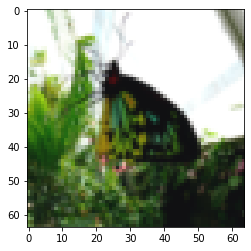

In [ ]:
# Örnek resim
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")

In [ ]:
# Verisetini inceleyelim 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Eğitim veri sayısı: " + str(m_train))
print ("Test veri sayısı: " + str(m_test))
print ("Bütün resimlerin ebatları: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Eğitim veri sayısı: 209
Test veri sayısı: 50
Bütün resimlerin ebatları: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


Genel olarak resimlerle ilgili bir ağ oluştururken ilk yapılacak işlem resimleri yeniden şekillendirerek standart bir boyuta getirmektir. Bununla ilgili Python kodları aşağıda verilmiştir.

<img src="https://github.com/mavzersener/derin_ogrenme/blob/master/images/imvectorkiank.png?raw=1" style="width:450px;height:300px;">

<caption><center><b>Şekil 7</b>: Resimden vektöre dönüştürmek <br> </center></caption>

In [ ]:
# Eğitim ve test örneklerimizi yeniden şekillendirelim 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # Burada "-1" yeniden şekillendirme ile kalan boyutları düzleştiriyor
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Veriyi 0 ve 1 değerleri alacak şekilde standardize ediyoruz.
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


Sonucunda elde edilen $12,288$ değeri $64 \times 64 \times 3$ olan boyutların tek bir yeniden şekillendirilmiş vektöre dönüştürülmüş halidir.

## 4.2. Modelimizin Mimarisi

Şimdi bir resmin kedi olup olmadığını tespit edebilen derin sinir ağımızı oluşturalım.

İki farkli model yapacağız:
- Bir 2-katmanlı sinir ağı 
- Bİr de Çoklu L-katmanlı derin sinir ağı

Tüm işlemler sonucunda iki modeli karşılaştıracağız ve aynı zamanda  farklı $L$  değerlerini denemiş olacağız. 



## 4.2. 2-Katmanlı Sinir Ağı

<img src="https://github.com/mavzersener/derin_ogrenme/blob/master/images/2layerNN_kiank.png?raw=1" style="width:650px;height:400px;">
<caption><center><b>Şekil 8: 2-Katmanlı Sinir Ağı</b> <br> Modelimiz şu şekilde özetlenebilir: <b>INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT</b></center></caption>

<u>Şekil 8'deki Mimarinin Detayları</u>:
- Girdi resmimiz $(64,64,3)$ boyutlarında iken  $(12288,1)$ boyutlarında bir vektöre dönüştürülüyor. 
- Bu $[x_0,x_1,...,x_{12287}]^T$ vektör sonra $(n^{[1]}, 12288)$ boyutunda $W^{[1]}$ ağırlık matrisi ile çarpılıyor.
- Buna bias eklenerek RELU işlemi uygularak şu vektör elde ediliyor:  $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Bu aynı süreci tekrar ediyoruz.
- Sonuç vektörünü $W^{[2]}$ ile çarparak bias (intercept) ekleniyor. 
- Nihayetinde ise sonucun sigmoid'i alınıyor. Bu değer 0.5'ten büyükse resmi kedi olarak sınıflandırıyoruz.



## 4.3. Çok katmanlı (L-Katman) Derin Sinir Ağı

L-Katmanlı daha derin bir sinir ağının başlangıcı daha karmaşıktır çünkü çok daha büyük ağırlık matrisi ve bias vektörü bulunmaktadır. Fonksiyonumuz `initialize_parameters_deep`, tamamlandığında her katmanın büyüklüğünün birbirine uyumlu olduğundan emin olmamız gerekmektedir. Öncelikle $n^{[l]}$ 'in $l$ katmanındaki birim sayısı olduğunu hatırlayalım. Bu bağlamda örnek verelim. Eğer girdi değeri olan $X$'in büyüklüğü $(12288, 209)$ ise  ($m=209$ örneklem sayısı) o zaman:

<table style="width:100%">
  <tr>
        <td>  </td> 
        <td> <b> W'in Şekli</b></td> 
        <td> <b>b'nin Şekli </b></td> 
        <td> <b> Aktivasyon </b></td>
        <td> <b> Aktivasyonun Şekli</b></td> 
  <tr>
    
  <tr>
        <td> <b> Katman 1 </b></td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},209)$ </td> 
  <tr>
    
  <tr>
        <td> <b>Katman 2</b></td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
  <tr>
   
  <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
  </tr>
    
  <tr>
        <td> <b>Katman L-1<b> </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
    <tr>
    
    
  <tr>
        <td> <b>Katman L</b> </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>

</table>

Hatırlayalım Python'da $W X + b$ hesaplandığında, program doğrudan sonucu veriyor. Örneğin, eğer: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{11}$$

O zaman $WX + b$ aşağıdaki gibi olacaktır:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{12}  $$

Çok katmanlı bir derin sinir ağını yukarıdaki gibi tasvir etmek kolay değil bu sebeple aşağıda basitleştirilmiş bir şekilde aşağıda sunulmuştur:

<img src="https://github.com/mavzersener/derin_ogrenme/blob/master/images/LlayerNN_kiank.png?raw=1" style="width:650px;height:400px;">
<caption><center><b>Şekil 9: Çok Katmanlı Derin Sinir Ağı (L-Katmanlı)</b> <br> Modelimizi şu şekilde özetleyebiliriz: <b> [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID </b></center></caption>



<u>Şekil 3'teki Mimarinin Detayları</u>:
- Girdi resmimiz $(64,64,3)$ boyutlarında iken  $(12288,1)$ boyutlarında bir vektöre dönüştürülüyor.
- Bu $[x_0,x_1,...,x_{12287}]^T$ vektör sonra $(n^{[1]}, 12288)$ boyutunda $W^{[1]}$ ağırlık matrisi ile çarpılıyor. Buna $b^{[1]}$ bias (intercept) ekleniyor. Elde edilen sonuç lineer birim olarak adlandırılıyor.
- Daha sonra bu birime RELU işlemi uyguluyoruz. Bu işlem modelin mimarisine göre her $(W^{[l]}, b^{[l]})$ için tekrardan yapılıyor. 
- Nihayetinde ise lineer birimin sigmoid'i alınıyor. Bu değer 0.5'ten büyükse resmi kedi olarak sınıflandırıyoruz.



## 4.4. İki Katmanlı Sinir Ağı Uygulaması

**Uygulama**:  Bir önceki bölümde tanımladığımız yardımcı fonksiyonları kullanarak aşağıdaki şekilde bir yapı oluşturacağız:
* LINEAR -> RELU -> LINEAR -> SIGMOID*. Daha önceki fonksiyonlara veri gönderip alırken aşağıda belirtilen şekilde fonksiyonları kullanıyoruz:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [ ]:
### MODELİMİZİN SABİTLERİNİ TANIMLAYALIM ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [ ]:
#  iKİ-KATMANLI MODELİMİZ

def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    İki katmanlı modelin uygulanması: LINEAR->RELU->LINEAR->SIGMOID.
    
    Girdiler:
    X -- girdi verisi, boyutu (n_x, örneklem sayısı)
    Y -- true "label" vektörü (içerisinde Eğer Kedi değilse 0, Kedi ise 1 değeri bulunan), boyutu (1, örneklem sayısı)
    layers_dims -- katmanların boyutu (n_x, n_h, n_y)
    num_iterations -- Optimize döngüsünün tekrar sayısı
    learning_rate -- Gradient descent güncelleme kuralının Öğrenme katsayısı (learning rate) 
    print_cost -- Eğer True olarak belirtilirse, her 100 iterasyonda maliyeti gösterecek 
    
    Çıktılar:
    parameters --  W1, W2, b1, ve b2 değerlerini içeren bir sözlük
    """
    
    
    grads = {}
    costs = []                              # maliyeti takip etmek için
    m = X.shape[1]                           # örneklem sayısı
    (n_x, n_h, n_y) = layers_dims
    
    # Parametre sözlüğünü başlatalım, bunun için daha önce yazdığımız fonksiyonu çağırıyoruz
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # W1, b1, W2 ve b2 değerlerini parametre sözlüğünden al.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Döngümüz (gradient descent)

    for i in range(0, num_iterations):

        # İleri Yayılım (Forward propagation): LINEAR -> RELU -> LINEAR -> SIGMOID. Girdiler: "X, W1, b1". Çıktılar: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # Maliyetin Hesaplanması
        cost = compute_cost(A2, Y)
        
        # Geriye Yayılımı başlatalım
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Geriye Yayılımı. Girdiler: "dA2, cache2, cache1". Çıktılar: "dA1, dW2, db2; aynı zamanda dA0 (kullanılmadı), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # Gradyanların ayarlanması ['dWl'] dW1'e, grads['db1'] db1'e, grads['dW2'] dW2'ye, grads['db2'] db2'ye
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Parametreleri güncelleyelim.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Parametrelerden  W1, b1, W2, b2 değerlerini alalım
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Her 100 eğitim örneğinde bir maliyeti yazdır
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # Maliyetin grafiğini yazdır

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Aşağıdaki kodu parametreleri eğitmek için çalıştıralım. Sonucunda maliyetin düşmesi gerekiyor. 2500 iterasyon için gerekli olan süre yaklaşık olarak 5 dakikadır. "Cost after iteration 0" değerimiz beklenen değer ile uyuşup uyuşmadığını kontrol ederek program hakkında geri dönüş alabilirsiniz. Eğer beklenen değerlere ulaşmadı ise (⬛) şeklindeki kareye basarak çalışmayı durdurun ve hata varsa kontrol edelim.

Cost after iteration 0: 0.6931095965797196
Cost after iteration 100: 0.6462527492239712
Cost after iteration 200: 0.6329721767074216
Cost after iteration 300: 0.6029282532337265
Cost after iteration 400: 0.5594423860047298
Cost after iteration 500: 0.5167311456159258
Cost after iteration 600: 0.4775126805102131
Cost after iteration 700: 0.424291289673379
Cost after iteration 800: 0.3865314827954213
Cost after iteration 900: 0.3476363612292267
Cost after iteration 1000: 0.3349755647597062
Cost after iteration 1100: 0.2936573558526964
Cost after iteration 1200: 0.2694808899820105
Cost after iteration 1300: 0.21418646133614885
Cost after iteration 1400: 0.16248725615542464
Cost after iteration 1500: 0.15655588939118106
Cost after iteration 1600: 0.13939455407975035
Cost after iteration 1700: 0.1132964429110816
Cost after iteration 1800: 0.07928364594343794
Cost after iteration 1900: 0.06933347767045499
Cost after iteration 2000: 0.05936883551915788
Cost after iteration 2100: 0.05268229442

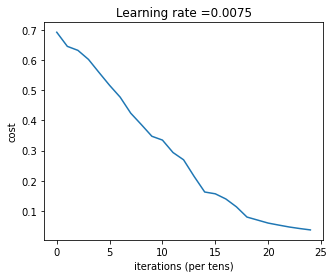

In [ ]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Beklenen Çıktı**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.693049735659989 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.6464283150388817 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.04950829635846386 </td>
    </tr>
</table>

Yaptığımız işlemi vektörize etmeseydik yaklaşık 10 kat daha fazla gerekecekti. Şimdi eğitilmiş parametrelerimizi veri setindeki resimleri sınıflandırmak için kullanabiliriz.

In [ ]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Beklenen Çıktı**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [ ]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.7000000000000001


**Beklenen Çıktı**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

## 4.5. Çok Katmanlı (L-Katman) Derin Sinir Ağı Uygulaması

Daha önce yaptığımız yardımcı fonksiyonları kullanarak aşağıdaki mimari ile uygulamamızı yapacağız:
* [LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. 
Daha önceki fonksiyonları aşağıdaki şekilde kullanacağız:

```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [ ]:
### SABİTLERİMİZ ###
layers_dims = [12288, 20, 5, 8, 1] #  5-KATMANLI MODEL

In [ ]:
 # L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=2500, print_cost=False): #lr was 0.009
    """
    Çok katmanlı sinir ağının uygulanması: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Girdiler:
    X -- veri, numpy array biçiminde ve şekli (number of examples, num_px * num_px * 3)
    Y -- true "label" vektörü (Kedi değilse 0 , Kedi ise 1 verisi içerir), şekli (1, number of examples)
    layers_dims -- Girdi boyutu ve her katmanın boyutunu içeren liste, uzunluğu (katman sayısı + 1).
    learning_rate -- Gradient Descent güncelleme kuralının öğrenme oranı  (learning rate)
    num_iterations -- Optimazisyon döngüsünü iterasyon sayısı
    print_cost -- Eğer True ise her 100 adımda bir maliyeti yazdırır
    
    Çıktılar:
    parameters -- model tarafından öğrenilern parametreler. Tahmin için kullanlabilir.
    """

    
    costs = []                         # Maliyeti takip edelim
    
    # Parameterleri başlatalım.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Döngümüz (gradient descent)
    for i in range(0, num_iterations):
        
        # İleri Yayılım: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Maliyetin hesaplanması.
        cost = compute_cost(AL, Y)
    
        # Geriye doğru yayılım.
        grads = L_model_backward(AL, Y, caches)
 
        # Parametreleri güncelleyelim.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Her 100 eğitim örneğinde bir maliyeti yazdır
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # Maliyetin grafiği
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Şimdi modelimizi 5 Katmanlı bir sinir ağında eğitiyoruz. 
Aşağıdaki kodu parametreleri eğitmek için çalıştıralım. Sonucunda maliyetin düşmesi gerekiyor. 2500 iterasyon için gerekli olan süre yaklaşık olarak 5 dakikadır. "Cost after iteration 0" değerimiz beklenen değer ile uyuşup uyuşmadığını kontrol ederek program hakkında geri dönüş alabilirsiniz. Eğer beklenen değerlere ulaşmadı ise (⬛) şeklindeki kareye basarak çalışmayı durdurun ve hata varsa kontrol edelim.


Cost after iteration 0: 0.709039
Cost after iteration 100: 0.669261
Cost after iteration 200: 0.638230
Cost after iteration 300: 0.576659
Cost after iteration 400: 0.501197
Cost after iteration 500: 0.422645
Cost after iteration 600: 0.387053
Cost after iteration 700: 0.342368
Cost after iteration 800: 0.195737
Cost after iteration 900: 0.129606
Cost after iteration 1000: 0.150653
Cost after iteration 1100: 0.063515
Cost after iteration 1200: 0.047673
Cost after iteration 1300: 0.037589
Cost after iteration 1400: 0.029224
Cost after iteration 1500: 0.018541
Cost after iteration 1600: 0.014615
Cost after iteration 1700: 0.011969
Cost after iteration 1800: 0.010047
Cost after iteration 1900: 0.008605
Cost after iteration 2000: 0.007485
Cost after iteration 2100: 0.006592
Cost after iteration 2200: 0.005868
Cost after iteration 2300: 0.005271
Cost after iteration 2400: 0.004774


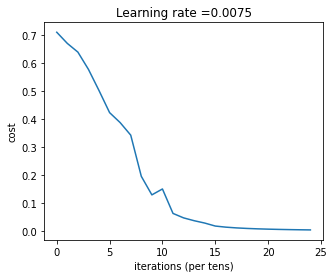

In [ ]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations=2500, print_cost=True)

**Beklenen Çıktı**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.673350 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.082077 </td>
    </tr>
</table>

In [ ]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    1.0
    </td>
    </tr>
</table>

In [ ]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.76


**Beklenen Çıktı**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.84 </td>
    </tr>
</table>

Görüldüğü üzere 5 katmanlı sinir ağımız (84%) iki katmana (72%) göre aynı testte daha iyi bir performans göstermiştir. 

Bu tarz bir göreve göre oldukça iyi bir performans sayılabilir. Müteakip safhada ise Derin sinir ağımızın bu performansını geliştirmek için hiperparametrelerimizi (learning_rate, layers_dims, num_iterations ve diğerleri) daha iyi hale getirmeye çalışacağız.  

**Hiper Parametreler ile Başarının Yükseltilmesi:**
**Early Stopping**: Dikkat edeceğiniz gibi daha az iterasyonla (1700 gibi) test verisinde istenen sonuçlara ulaşabiliyoruz. Erken durdurma hem işlemci yükünü azaltıyor hem de overfitting durumuna da engel oluyor.
**Öğrenme Oranı (Learning Rate):** Bu oranı değiştirerek Test Accuracy değeri yükseltilebiliyor. Örneğin:
> 0.0075---> Accuracy:
> 0.009----> Accuracy: 

**Katman Sayısı:** Katman sayısını artırarak Yapay Sinir Ağımızın derinliğini arttırabiliriz. Örneğimzde:
> 2 Katmanlı Ağın Accuracy: 
> 5 Katmanlı Ağın Accuracy:
> 7 Katmanlı Ağın Accuracy:
> 9 Katmanlı Ağın Accuracy:
> 20 Katmanlı Ağın Accuracy:


# Sonuçların Analizi



## 5.1. Hatalı Sınıflandırma

Öncelikle Çok Katmanlı (L-Katman) modelimiz tarafından hatalı etiketlenen resimlere bakalım. Aşağıda yanlış etiketlenmiş bazı resimler görülmektedir. 

In [ ]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

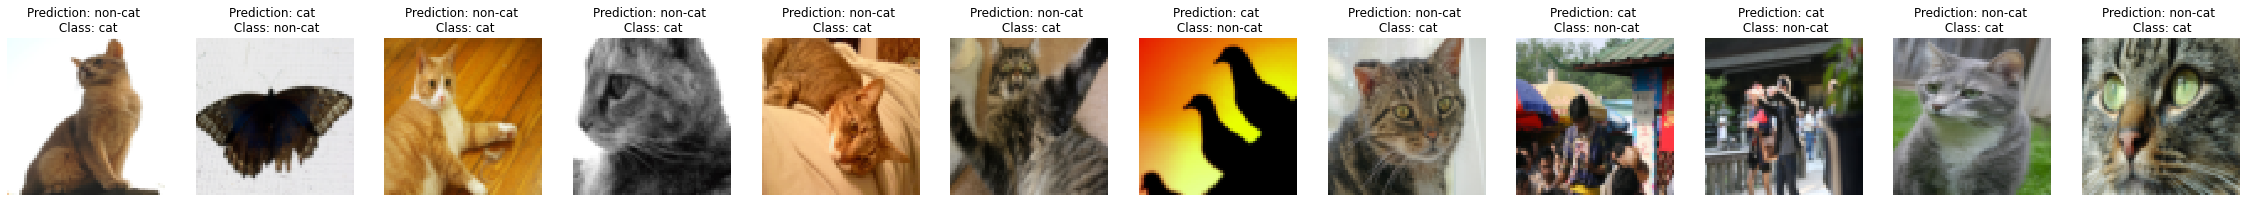

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**Aşağıdaki türdeki resimlerin model tarafından hatalı sınıflandırılma eğilimi olduğu görülüyor:** 
- Alışılmadık bir şekilde duran kediler
- Arkaplanın kedinin rengine benzerlik gösterdiği resimler
- Sıradışı kedi tür ve renkleri
- Kamera açısı
- Resmin parlaklığı
- Ölçek farklılıkları (Kedi resimde çok büyük ya da küçük) 

## 5.2. Başka resimler ile test edelim ##

Modelimizi tamamladık şimdi veri setinde bulunmayan başka kedi resimleri ile modelimizi yeniden deneyebiliriz. Bunu yapmak için:
    1. Notebook'ta bulunan  "File" sekmesini açıp  "Open" tıklatıyoruz.
    2. Jupyter Notebook klasöründe "images" klasörüne resmi kaydediyoruz.
    3. Aşağıdaki koddaki isimle resim dosyasının adını değiştiriyoruz.
    4. AŞağıdaki kodu çalıştırarak algoritmamızın doğru çalışıp çalışmadığına bakabiliriz. (1 = kedi, 0 = kedi değil).

In [ ]:
my_image = "my_image.png" # resim dosyasının adını bu şekilde yapın 
my_label_y = [1] # resmin sınıflandırılması (1 -> kedi, 0 -> kedi değil)

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

# **Kaynakça**

- Neural Networks and Deep Learning, Andrew Ng, Kian Katanforoosh, Younes Bensouda Mourri, https://www.coursera.org/learn/neural-networks-deep-learning, 2021
- Yapay sinir ağlar, Ercan Öztemel, Papatya Yayıncılık, Istanbul, 2003
- Veri Seti ve Kodlar için, https://github.com/mavzersener/derin_ogrenme. 
